Notebook associated with the study carried out in the post [Is it profitable to trade with bitcoin from the Fear and Greed index?](https://bgeometrics.com/2022/11/02/is-it-profitable-to-trade-bitcoin-from-the-fear-and-greed-index/) on how related the Fear and Greed indicator is to the price of bitcoin (BTC).

# What is the fear and greed index?
It is a metric that tries to guess the sentiment of the market, if it is positive (>50) it presupposes that there will be greater demand for BTC so the price will rise and if it is negative (<50) it will result in the sale of the asset with the consequent fall in price. price. The alternative indicator for bitcoin is published from 2/5/2018.

In [1]:
!pip install yfinance > /dev/null

In [2]:
import pandas as pd
import numpy as np 
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import warnings

warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10, 5

# Data import Fear and Greed index

Data download of https://alternative.me/crypto/fear-and-greed-index/
The index fear_greed that shows today is the value calculated with yesterday's data.

In [3]:
r = requests.get('https://api.alternative.me/fng/?limit=0')

# Data Exploration

Show fear and greed index since the beginning of the year 2018
The values range between 0 and 100, with low values indicating fear and high values indicating euphoria.

<AxesSubplot:xlabel='timestamp'>

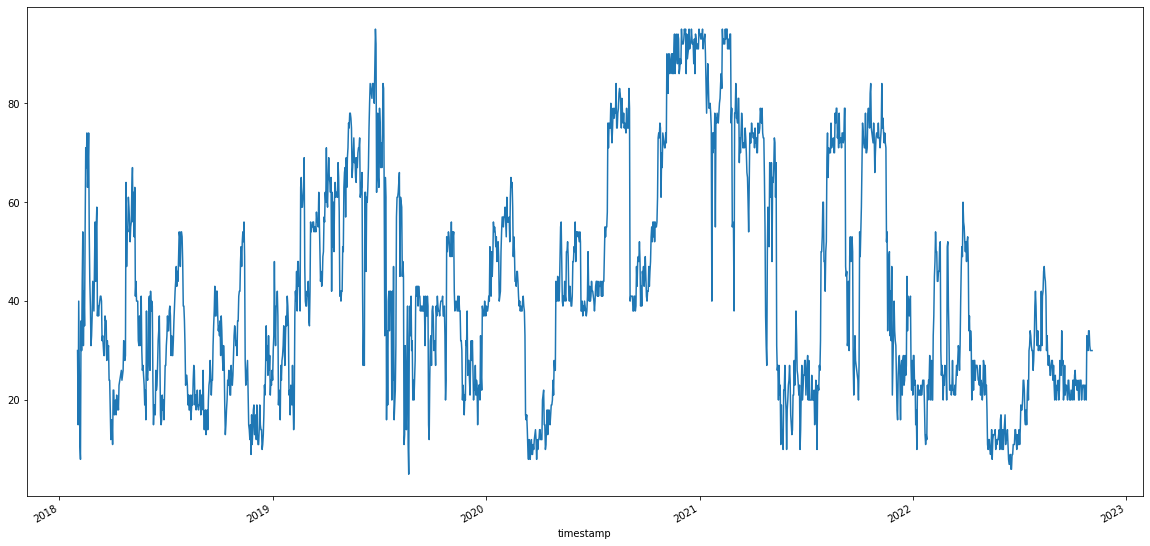

In [4]:
df = pd.DataFrame(r.json()['data'])
df.value = df.value.astype(int)
df.timestamp = pd.to_datetime(df.timestamp, unit='s')
df.set_index(df.timestamp, inplace=True)
df.rename(columns = {'value':'fear_greed'}, inplace=True)
df.drop(['timestamp', 'time_until_update'], axis=1, inplace=True)
df.fear_greed.plot(figsize=(20,10))

Show in a graph the distribution of the values of the fear and euphoria index
Where it can be seen that in this period the most recurrent values are around 20 and 40, which are indicators of fear.


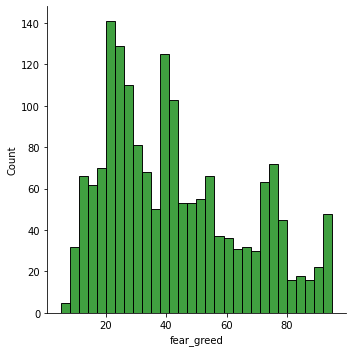

In [5]:
sns.displot(df['fear_greed'], color='g', bins=30)

The mean and median values are around 40, which indicates that fear prevails over euphoria.

Mean: 42.52622478386167
Median: 39.0


<AxesSubplot:xlabel='fear_greed'>

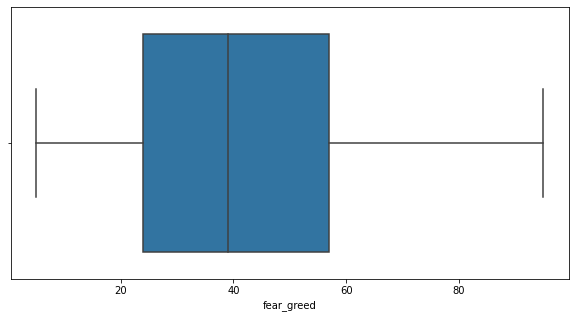

In [6]:
print("Mean: " + str(df.fear_greed.mean()))
print("Median: " + str(df.fear_greed.median()))
sns.boxplot(x='fear_greed', data=df)

# Autocorrelation

There is a high autocorrelation in the fear and greed index that decreases little by little as the days go by
It is normal since fear and greed work for periods it is not usual to go from extreme fear one day to high greed the next day
Today's index is more likely to be more like yesterday's than 2 weeks ago as trend changes take time to occur.

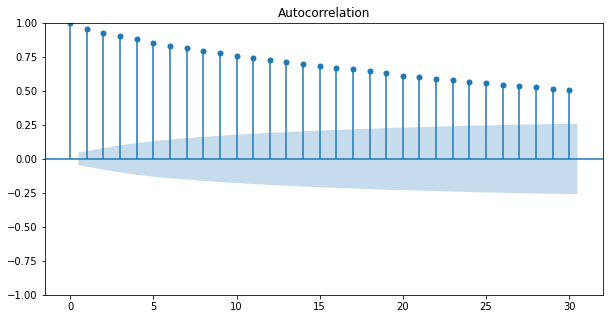

In [7]:
plot_acf(df["fear_greed"], lags=30)
plt.show()

The partial autocorrelation is strong with respect to yesterday, a little more with the day before yesterday, but after those two days
Does not exist since they are statistically insignificant since they are within the confidence interval (shaded part).

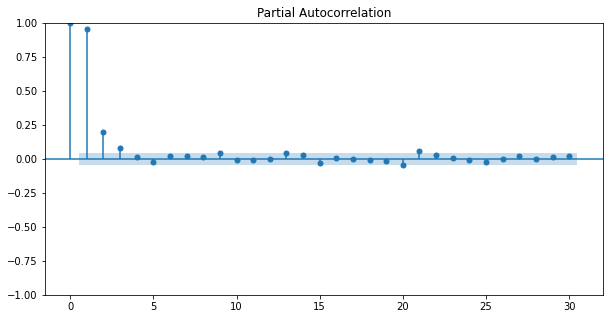

In [8]:
plot_pacf(df["fear_greed"], lags=30)
plt.show()

But if we focus on the variations of the index from one day to the next, we do find a great randomness.


<AxesSubplot:xlabel='timestamp'>

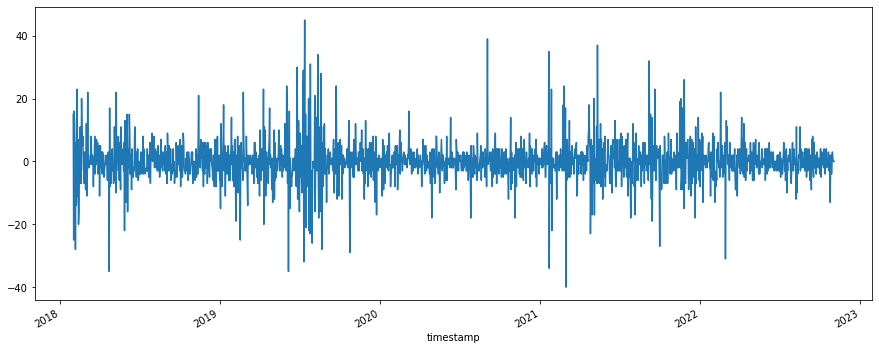

In [9]:
df.fear_greed.diff().plot(figsize=(15,6))

There is no such autocorrelation in the difference of the value of a day with that of its predecessor or later that we had for the absolute values.


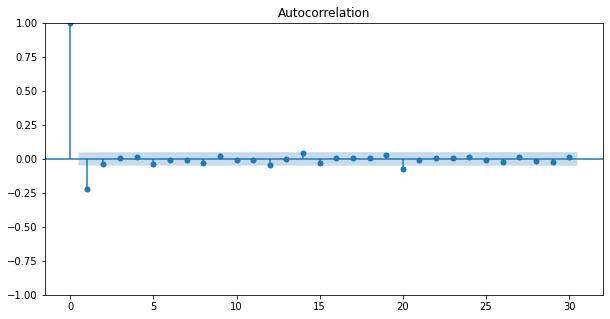

In [10]:
plot_acf(df["fear_greed"].diff().dropna(),lags=30)
plt.show()

If the distribution of values of the difference is shown, we see that it is an almost normal distribution centered on a value close to 0.


<AxesSubplot:xlabel='fear_greed', ylabel='Density'>

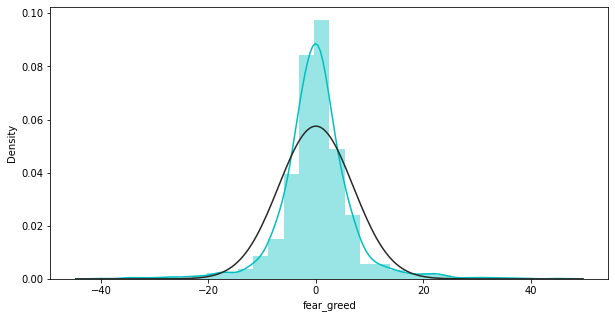

In [11]:
sns.distplot(df.fear_greed.diff(), color='c', bins=30, fit=norm)

# Data import BTC Price in USD

Data Bitcoin price download of yahoo finance

In [12]:
df1 = yf.download('BTC-USD', interval = '1d')[['Close']]
df1.rename(columns = {'Close':'close'}, inplace=True)
df1.index.name = 'timestamp'
df1['timestamp'] = df1.index
df1.reset_index(drop=True, inplace=True)
df1.timestamp = pd.to_datetime(df1.timestamp, unit='s').dt.tz_localize(None)
df1.set_index(df1.timestamp, inplace=True)
df1.drop(['timestamp'], axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


The fear and greed index data is merged with the bitcoin price data in dollars.

In [13]:
data = df.merge(df1, on='timestamp')
data = data.sort_index()
data.tail()

,fear_greed,value_classification,close
timestamp,,,
2022-10-31,31,Fear,20495.773438
2022-11-01,30,Fear,20485.273438
2022-11-02,30,Fear,20159.503906
2022-11-03,30,Fear,20209.988281
2022-11-04,30,Fear,20761.925781


The graph of the price of bitcoin during that same period
Briefly analyzed we see a relative stability between 2018 and the end of 2020
Subsequently a very pronounced rise until the end of the first quarter of 2021
Then a descent followed by a big rise ending at the end of 2022
And since then a bearish period

<AxesSubplot:xlabel='timestamp'>

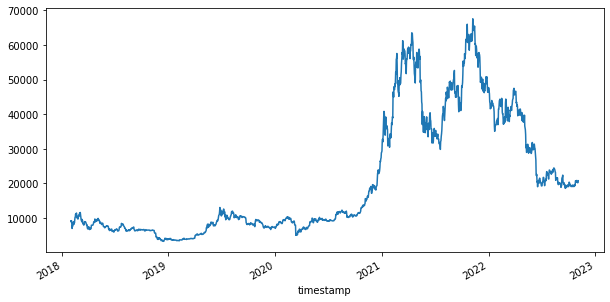

In [14]:
data.close.plot()

The fear and greed index is published at 00:00 UTC taking into account the data of the previous day
The closing data of the bitcoin price is the value at 00:00 UTC
Therefore, in order to make money, the value to be compared with is the closing price of the next day.

A column is included with the data from tomorrow's close and the difference between the two values.
Another columns with returns in value today and tomorrow and change ntc price.


In [15]:
data['close_tomorrow'] = data['close'].shift(-1)
data['returns'] = data['close_tomorrow'] / data['close'] - 1
data['change_btc'] = (data['returns'] + 1).cumprod()
data = data.dropna()

We perform a correlation between the F&G index and the closing price of BTC the next day
A total correlation would be 1 and 0 indicates that there is no correlation, so 0.24 indicates that there is a slight correlation.

In [16]:
data['fear_greed'].corr(data['close_tomorrow'])

0.2399161787118079

# Bitcoin Trading Strategy

A basic BTC purchase strategy is analyzed when the fear and greed index is greater than 50 and when it is less than that value, nothing is done.

In [17]:
data['signal'] = np.where(data.fear_greed > 50, 1, 0)
data['strategy'] = (data['returns'] +1) ** data['signal']
data['cumulative'] = data[['strategy']].dropna().cumprod()
data.tail()

,fear_greed,value_classification,close,close_tomorrow,returns,change_btc,signal,strategy,cumulative
timestamp,,,,,,,,,
2022-10-30,34,Fear,20635.603516,20495.773438,-0.006776,2.234958,0,1.0,6.430156
2022-10-31,31,Fear,20495.773438,20485.273438,-0.000512,2.233813,0,1.0,6.430156
2022-11-01,30,Fear,20485.273438,20159.503906,-0.015903,2.198290,0,1.0,6.430156
2022-11-02,30,Fear,20159.503906,20209.988281,0.002504,2.203795,0,1.0,6.430156
2022-11-03,30,Fear,20209.988281,20761.925781,0.027310,2.263981,0,1.0,6.430156


Graph of the performance of the strategy compared to the evolution of the price.

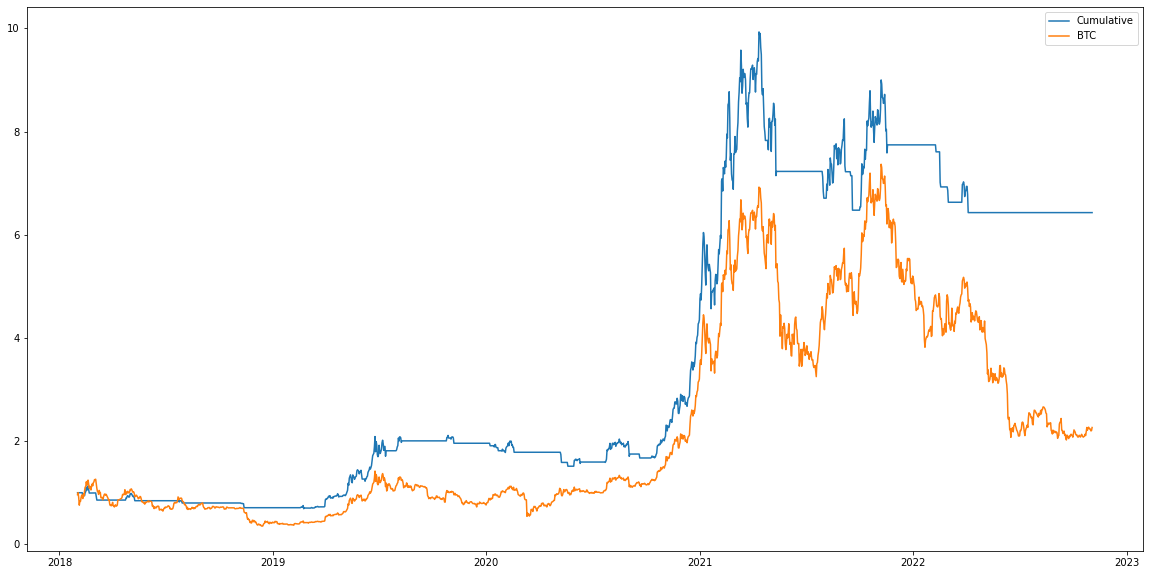

In [18]:
plt.figure(figsize=(20,10))
plt.plot(data['cumulative'], label ='Cumulative')
plt.plot(data['change_btc'], label ='BTC')
plt.legend()

It is clearly observed that it is a good strategy for the period studied.

In [19]:
print('Initial value: \t' + str(data['cumulative'].iloc[1]))
print('End value: \t' + str(data['cumulative'].iloc[-2]))
print('End value BTC: \t' + str(data['change_btc'].iloc[-2]))

Initial value: 	1.0
End value: 	6.430155875523231
End value BTC: 	2.2037947814593477


# Profit

I carry out the most realistic practical exercise starting with an initial investment and adding a commission on purchases and sales
Everything is sold when the buy signal runs out since in this strategy all the capital is used for buying and selling and the money is needed to buy again.

In [20]:
def profit_calculation (_data, _initial_capital, _feeds):
    n_buy_sell = 0
    sell = 0
    profit = _initial_capital
    i = 0
    _buy_where = []
    _sell_where = []

    for date,row in data.iterrows(): 
        i+=1 
        if row['signal'] == 1:
            n_buy_sell += 1                
            buy = (profit / row['close'])*(1-_feeds) 
            _data.at[date, 'buy'] = buy
            profit = buy * row['close_tomorrow']
            _data.at[date, 'profit'] = profit
            sell = profit
            _buy_where.append(i)

        elif sell != 0:
            n_buy_sell += 1
            sell_BTC = (sell/ row['close'])*(1-_feeds) 
            _data.at[date, 'profit'] = profit
            _data.at[date, 'sell'] = sell_BTC
            profit = sell
            sell = 0
            _sell_where.append(i)

    print("Nº buy and sell: \t" + str(n_buy_sell))
    print("Feeds: \t\t\t" + str(_feeds) + "%")
    print("Initial capital: \t$" + str(_initial_capital))
    print("End capital: \t\t$" + str(round(profit,2)))
    print("Profit: \t\t$" + str(round(profit - _initial_capital, 2)))

    return(_buy_where, _sell_where)

Initial investment of $10,000 and a commission of 0.3%.


In [21]:
feeds = 0.003
initial_capital = 10000
buy_where, sell_where = profit_calculation(data, initial_capital, feeds)

Nº buy and sell: 	619
Feeds: 			0.003%
Initial capital: 	$10000
End capital: 		$11846.65
Profit: 		$1846.65


# Chart of when buying and selling

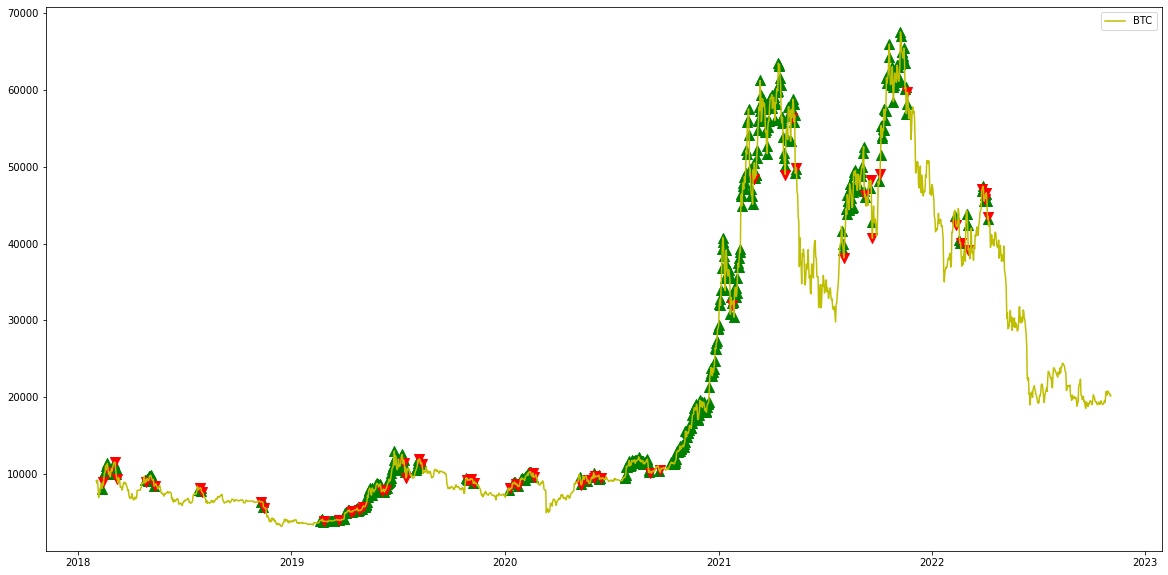

In [22]:
plt.figure(figsize=(20,10))
plt.plot(data.close, label='BTC', c='y')
plt.scatter(data.iloc[buy_where].index,data.iloc[buy_where]['close'],marker='^',color='g',s=100)
plt.scatter(data.iloc[sell_where].index,data.iloc[sell_where]['close'],marker='v',color='r',s=100)
plt.legend()
plt.show()